In [1]:
import logging
from glob import glob

from live2p.workers import RealTimeQueue
from live2p.utils import (get_nchannels, get_nvols, 
                          get_tslice, ptoc, slice_movie, 
                          tic, get_true_mm3d_range)
from live2p.offline import run_plane_offline

# logging setup
# change for more or less information...
caiman_loglevel = logging.INFO
live2p_loglevel = logging.DEBUG

# changes how logs/updates are printed
logformat = '{relativeCreated:08.0f} - {levelname:8} - [{module}:{funcName}:{lineno}] - {message}'
logging.basicConfig(level=caiman_loglevel, format=logformat, style='{') #sets caiman loglevel
logger = logging.getLogger('live2p')
logger.setLevel(live2p_loglevel) # sets live2p debug level

In [2]:
# experiment info
# put the makeMasks3D image mat file in the folder with your data
tiff_folder = 'e:/caiman_scratch/test_data/ori/data'

plane = 0 # index starts at 0 (for single plane)
nplanes = 3 # for running multiple planes
fr = 6.36

# x_start and x_end need to be the same or larger than what is in mm3d
# x_start = 110
# x_end = 512-110
# we can auto-determine them now...
# but note: if the stim/vis artifact is in the cropped range, there will be problems
# with motion correction and/or F extraction
mm3d_path = glob(tiff_folder + '/*.mat')[0]
x_start, x_end = get_true_mm3d_range(mm3d_path)
print(f'makeMasks3D range determine to be: {x_start} to {x_end} (pixels)')

# pre-allocated frame buffer, per plane
max_frames = 30000

n_init = 500

makeMasks3D range determine to be: 106 to 404 (pixels)


In [7]:
params = {
    'fr': fr,
    'p': 1,  # deconv 0 is off, 1 is slow, 2 is fast
    'nb': 3,  # background compenents -> nb: 3 for complex
    'decay_time': 1.0,  # sensor tau
    'gSig': (5, 5),  # expected half size of neurons in pixels, very important for proper component detection
    'init_method': 'seeded',
    'motion_correct': True,
    'expected_comps': 500,
    'update_num_comps': False,
    'update_freq': 100,
    'niter_rig': 2,
    'pw_rigid': False,
    'dist_shape_update': False,
    'normalize': True,
    'sniper_mode': False,
    'test_both': False,
    'ring_CNN': False,
    'simultaneously': True,
    'use_cuda': False,
}

add_cells = {
    'only_init':True,
    'rf':None,
    'update_num_comps':True
}

params = {**params, **add_cells}

In [4]:
# run a single plane offline
# result = run_plane_offline(plane, tiff_folder, params, x_start, x_end, n_init, max_frames)

In [8]:
# run all planes offline
# as run_plane_offline is already multi-process, so the simplest way to do this is to run planes sequentially

t = tic()
data = []
for p in range(nplanes):
    print(f'***** Starting Plane {p} *****')
    result = run_plane_offline(p, tiff_folder, params, x_start, x_end, n_init, max_frames)
    data.append(result)
print('All done!')
ptoc(t, 'Whole thing took')

***** Starting Plane 0 *****
getting files for initialization....


92208017 - DEBUG    - [workers:__init__:45] - Setting up params...
92208021 - INFO     - [params:set:972] - Changing key fr in group data from 30 to 6.36
92208025 - INFO     - [params:set:972] - Changing key decay_time in group data from 0.4 to 1.0
92208027 - INFO     - [params:set:972] - Changing key p in group preprocess from 2 to 1
92208029 - INFO     - [params:set:972] - Changing key nb in group init from 1 to 3
92208030 - INFO     - [params:set:972] - Changing key gSig in group init from [5, 5] to (5, 5)
92208032 - INFO     - [params:set:972] - Changing key nb in group spatial from 1 to 3
92208033 - INFO     - [params:set:972] - Changing key p in group temporal from 2 to 1
92208034 - INFO     - [params:set:972] - Changing key nb in group temporal from 1 to 3
92208036 - INFO     - [params:set:972] - Changing key init_method in group online from bare to seeded
92208037 - INFO     - [params:set:972] - Changing key update_freq in group online from 200 to 100
92208039 - INFO     - [par

starting initialization...


92208424 - INFO     - [workers:__init__:202] - Starting live2p worker.
92208426 - INFO     - [workers:initialize_onacid:220] - Starting new OnACID initialization for live2p.
92208427 - DEBUG    - [workers:make_init_mmap:225] - Making init memmap...


Plane 0: Found 99 sources from MM3D...


92210400 - INFO     - [params:set:972] - Changing key init_batch in group online from 200 to 500
92211568 - DEBUG    - [workers:make_init_mmap:243] - Init mmap saved to initplane0_d1_512_d2_298_d3_1_order_C_frames_500_.mmap.
92211611 - INFO     - [params:set:972] - Changing key fnames in group data from None to initplane0_d1_512_d2_298_d3_1_order_C_frames_500_.mmap
92213718 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
92219373 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
92225132 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
92231591 - INFO     - [online_cnmf:initialize_online:967] - Frame size:(512, 298)
C:\Users\Will\miniconda3\envs\live2p\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceW

starting queue...
starting worker...


92261567 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92265306 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92269363 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92272956 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92276914 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92277108 - INFO     - [workers:process_frame_from_queue:346] - Total of 1000 frames processed. (Queue 0)
92277109 - INFO     - [workers:process_frame_from_queue:350] - Average processing time: 225 ms. (4.44 Hz) (Queue 0)
92281428 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92286037 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92290496 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92294987 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92299816 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92300005 - INFO     - [workers:process_frame_from_queue:346] - Total of 1500 frames processed. (Queue 0)
9230

done!


92601950 - INFO     - [cluster:stop_server:344] - No cluster to stop...
92601953 - INFO     - [cluster:stop_server:358] - stop_cluster(): done
92601955 - DEBUG    - [workers:_stop_cluster:97] - Cluster stopped.
92601960 - DEBUG    - [workers:__del__:75] - Worker object destroyed on delete.


***** Starting Plane 1 *****
getting files for initialization....


92602952 - DEBUG    - [workers:__init__:45] - Setting up params...
92602954 - INFO     - [params:set:972] - Changing key fr in group data from 30 to 6.36
92602955 - INFO     - [params:set:972] - Changing key decay_time in group data from 0.4 to 1.0
92602957 - INFO     - [params:set:972] - Changing key p in group preprocess from 2 to 1
92602958 - INFO     - [params:set:972] - Changing key nb in group init from 1 to 3
92602959 - INFO     - [params:set:972] - Changing key gSig in group init from [5, 5] to (5, 5)
92602960 - INFO     - [params:set:972] - Changing key nb in group spatial from 1 to 3
92602961 - INFO     - [params:set:972] - Changing key p in group temporal from 2 to 1
92602963 - INFO     - [params:set:972] - Changing key nb in group temporal from 1 to 3
92602963 - INFO     - [params:set:972] - Changing key init_method in group online from bare to seeded
92602964 - INFO     - [params:set:972] - Changing key update_freq in group online from 200 to 100
92602966 - INFO     - [par

starting initialization...


92603346 - INFO     - [workers:__init__:202] - Starting live2p worker.
92603349 - INFO     - [workers:initialize_onacid:220] - Starting new OnACID initialization for live2p.
92603353 - DEBUG    - [workers:make_init_mmap:225] - Making init memmap...


Plane 1: Found 111 sources from MM3D...


92605158 - INFO     - [params:set:972] - Changing key init_batch in group online from 200 to 500
92606287 - DEBUG    - [workers:make_init_mmap:243] - Init mmap saved to initplane1_d1_512_d2_298_d3_1_order_C_frames_500_.mmap.
92606314 - INFO     - [params:set:972] - Changing key fnames in group data from None to initplane1_d1_512_d2_298_d3_1_order_C_frames_500_.mmap
92608683 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
92608757 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
92614529 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
92614604 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
92620241 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
92620315 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
92626849

starting queue...
starting worker...


92658854 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92663280 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92667553 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92671704 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92675878 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92676101 - INFO     - [workers:process_frame_from_queue:346] - Total of 1000 frames processed. (Queue 1)
92676102 - INFO     - [workers:process_frame_from_queue:350] - Average processing time: 257 ms. (3.89 Hz) (Queue 1)
92679741 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92683629 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92687597 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92691697 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92695588 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
92695807 - INFO     - [workers:process_frame_from_queue:346] - Total of 1500 frames processed. (Queue 1)
9269

done!


92992212 - INFO     - [cluster:stop_server:344] - No cluster to stop...
92992216 - INFO     - [cluster:stop_server:358] - stop_cluster(): done
92992220 - DEBUG    - [workers:_stop_cluster:97] - Cluster stopped.
92992223 - DEBUG    - [workers:__del__:75] - Worker object destroyed on delete.


***** Starting Plane 2 *****
getting files for initialization....


92993157 - DEBUG    - [workers:__init__:45] - Setting up params...
92993159 - INFO     - [params:set:972] - Changing key fr in group data from 30 to 6.36
92993160 - INFO     - [params:set:972] - Changing key decay_time in group data from 0.4 to 1.0
92993161 - INFO     - [params:set:972] - Changing key p in group preprocess from 2 to 1
92993162 - INFO     - [params:set:972] - Changing key nb in group init from 1 to 3
92993164 - INFO     - [params:set:972] - Changing key gSig in group init from [5, 5] to (5, 5)
92993168 - INFO     - [params:set:972] - Changing key nb in group spatial from 1 to 3
92993170 - INFO     - [params:set:972] - Changing key p in group temporal from 2 to 1
92993172 - INFO     - [params:set:972] - Changing key nb in group temporal from 1 to 3
92993173 - INFO     - [params:set:972] - Changing key init_method in group online from bare to seeded
92993174 - INFO     - [params:set:972] - Changing key update_freq in group online from 200 to 100
92993176 - INFO     - [par

starting initialization...


92993532 - INFO     - [workers:__init__:202] - Starting live2p worker.
92993534 - INFO     - [workers:initialize_onacid:220] - Starting new OnACID initialization for live2p.
92993536 - DEBUG    - [workers:make_init_mmap:225] - Making init memmap...


Plane 2: Found 104 sources from MM3D...


92995319 - INFO     - [params:set:972] - Changing key init_batch in group online from 200 to 500
92996415 - DEBUG    - [workers:make_init_mmap:243] - Init mmap saved to initplane2_d1_512_d2_298_d3_1_order_C_frames_500_.mmap.
92996444 - INFO     - [params:set:972] - Changing key fnames in group data from None to initplane2_d1_512_d2_298_d3_1_order_C_frames_500_.mmap
92998835 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
92998930 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
93004726 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
93004800 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
93010491 - WARNING  - [movies:extract_shifts:371] - Movie average is negative. Removing 1st percentile.
93010565 - WARNING  - [movies:extract_shifts:389] - Movie average is negative. Removing 1st percentile.
93016733

starting queue...
starting worker...


93046320 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
93050332 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
93054406 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
93058266 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
93062038 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
93062257 - INFO     - [workers:process_frame_from_queue:346] - Total of 1000 frames processed. (Queue 2)
93062258 - INFO     - [workers:process_frame_from_queue:350] - Average processing time: 251 ms. (3.97 Hz) (Queue 2)
93065934 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
93069825 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
93074002 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
93078246 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
93082340 - INFO     - [online_cnmf:fit_next:769] - Updating Shapes
93082550 - INFO     - [workers:process_frame_from_queue:346] - Total of 1500 frames processed. (Queue 2)
9308

done!


93372520 - INFO     - [cluster:stop_server:344] - No cluster to stop...
93372524 - INFO     - [cluster:stop_server:358] - stop_cluster(): done
93372528 - DEBUG    - [workers:_stop_cluster:97] - Cluster stopped.
93372532 - DEBUG    - [workers:__del__:75] - Worker object destroyed on delete.


All done!
Whole thing took 1165.5366 s


1165.5365611000016

### Once that is all done the data is returned into a list of python dictionaries

So to access the results of a single plane, index into the list and then access fields in the dictionary with a string.

`data[plane_idx]['plane']` returns the plane number

`data[plane_idx]['C']` returns the denoised spatial components

`data[plane_idx]['nC']` returns the raw signal (or something close to it)

Note: the data is stored as lists NOT np.arrays, so to use them you need to convert them to arrays with `np.array(list)` or concatenate the lists (eg. C values for all planes) which will also return a np.array

In [9]:
data[0].keys()

dict_keys(['plane', 't', 'A', 'b', 'C', 'f', 'nC', 'YrA', 'CoM', 'dims', 'shifts'])

### Make and save the data as a .mat:

In [10]:
import numpy as np
import scipy.io as sio

In [11]:
# make CoMs have z_value
planes = [0,1,2]
# planes = [0, 30 60]

locs = []
for i,dat in enumerate(data):
    z_plane = planes[i]
    coms = np.array(dat['CoM'], dtype=int)
    ps = np.full((coms.shape[0],1), fill_value=z_plane)
    xyz = np.hstack((coms, ps))
    locs.append(xyz)
    
locs = np.vstack(locs)

In [12]:
# c is denoiced, nC is raw, a is spatial
c = np.concatenate([dat['C'] for dat in data])
nC = np.concatenate([dat['nC'] for dat in data])
a = np.hstack([dat['A'] for dat in data])

In [ ]:
mat = {
    'c':c,
    'nC':nC,
    'a':a,
    'locs':locs
}

fpath_to_save = 'path/to/save/fname.mat'
sio.savemat(fpath_to_save, mat)

## Play with data in python

In [13]:
import matplotlib.pyplot as plt

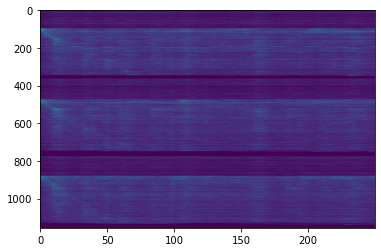

In [15]:
plt.imshow(c[:,:250], aspect='auto')

Text(0.5, 0.98, 'Denoised Traces')

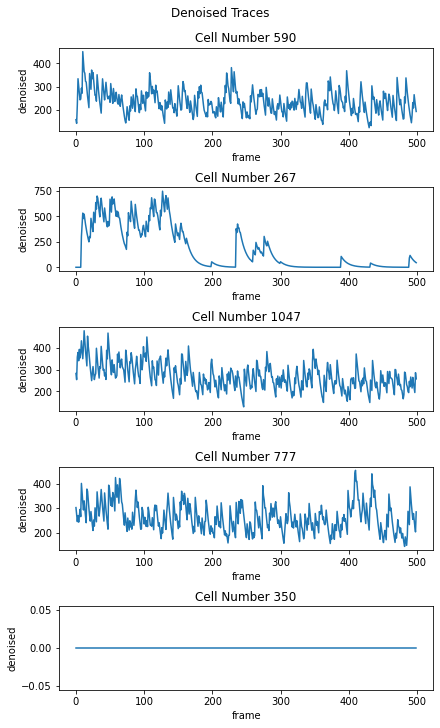

In [16]:
randcells = np.random.choice(np.arange(c.shape[0]), 5, replace=False)
fig, axes = plt.subplots(5,1, constrained_layout=True, figsize=(6,10))

for ax,rc in zip(axes, randcells):
    ax.plot(c[rc, :500])
    ax.set_title(f'Cell Number {rc}')
    ax.set_ylabel('denoised')
    ax.set_xlabel('frame')
    
fig.suptitle('Denoised Traces')

Text(0.5, 0.98, 'Noisy Traces')

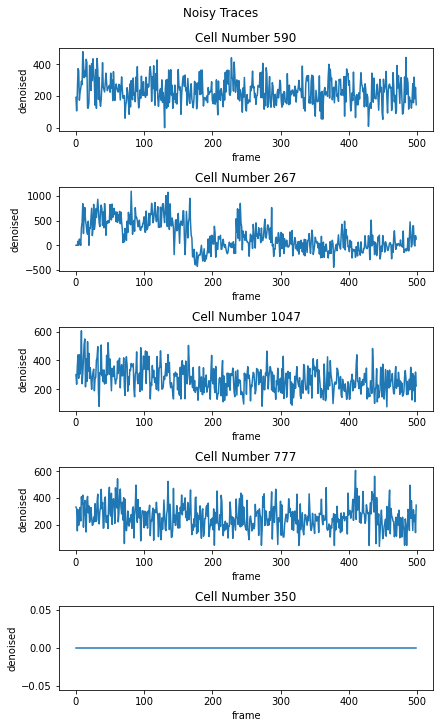

In [17]:
# randcells = np.random.choice(np.arange(c.shape[0]), 5, replace=False)
fig, axes = plt.subplots(5,1, constrained_layout=True, figsize=(6,10))

for ax,rc in zip(axes, randcells):
    ax.plot(nC[rc, :500])
    ax.set_title(f'Cell Number {rc}')
    ax.set_ylabel('denoised')
    ax.set_xlabel('frame')
    
fig.suptitle('Noisy Traces')

In [19]:
dims = data[0]['dims']
a2 = a.reshape((*dims, -1), order='F')
a2.shape

(512, 298, 1156)

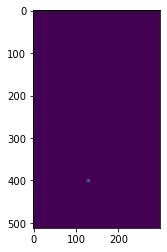

In [20]:
cell = 55
plt.imshow(a2[:,:,cell])

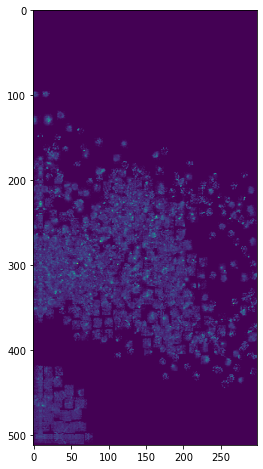

In [24]:
fig, ax = plt.subplots(1,1, figsize=(4,8))
ax.imshow(a2.max(2), aspect='auto')